# Bank marketing

### Importing and installing

In [ ]:
!pip install xgboost -U -q
!pip install sklearn -U -q
!pip install shap

In [ ]:
#Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.utils import resample

#For SML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.metrics import classification_report

In [ ]:
!pip install umap-learn -q

In [ ]:
#importing relevant packages
import altair as alt
import umap
from sklearn.cluster import KMeans

### Basic EDA and cleaning

In [ ]:
#Importing our data hosted on GitHub
data_raw = pd.read_csv("https://raw.githubusercontent.com/Ceges98/BDS-Project/main/bank_marketing.csv", sep=";")

Firstly we drop all data containing unknown, we discussed different options in the group and decided to do it this way.

There is unknown (missing values) in all Bank Client features except age.

After looking at different plots we see the category "default" has either the options no or unknown and very few oberservations with yes, therefore we drop that column before dropping the missing values. 

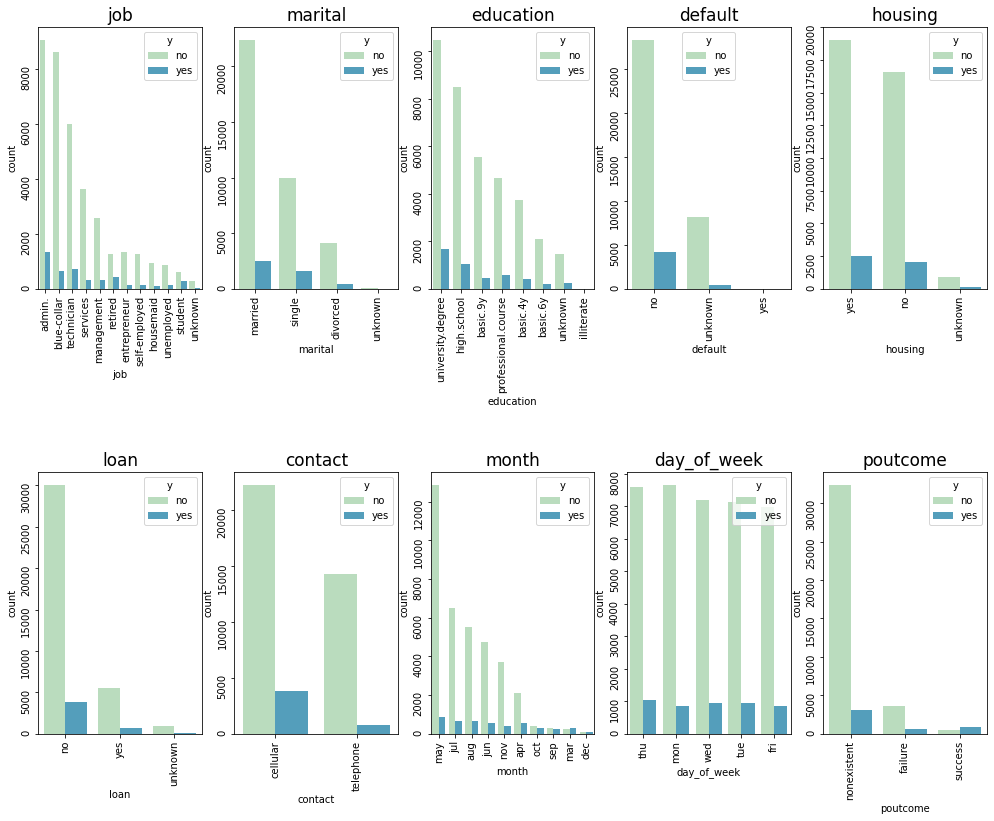

In [ ]:
#Showing all variables with categories
fig, ax = plt.subplots(2,5, figsize=(17,13))
cat = data_raw.select_dtypes('object').columns.to_list()
cat = cat[:-1]
ax = ax.ravel()
position = 0
for i in cat:
    
    order = data_raw[i].value_counts().index
    sns.countplot(data=data_raw, x=i, ax=ax[position], hue='y', palette='GnBu', order=order)
    ax[position].tick_params(labelrotation=90)
    ax[position].set_title(i, fontdict={'fontsize':17})
    
    position += 1

plt.subplots_adjust(hspace=0.7)

plt.show()

In [ ]:
#dropping the default feature, since this gives us little to no information
data_raw = data_raw.drop(columns = "default")

It could aswell be argued that weekday could be dropped. But since it has a little variation we decided to keep it.

Further month gives us the information that most campaigns ran in may. We also keep this variable.

In regards to who says yes and who says no we also have several conclusions that we can draw:
1. Students and retired are the two 'jobs' with the highest yes-percentage.
2. Single costumers agreed more often measured relative to married.
3. Calling a cellular device had a higher success rate than telephones.
4. Owning a house did had very little effect yes/no rate.

Dropping unknowns stepwise:

In [ ]:
#Seeing which values job has
data_raw.job.value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [ ]:
data_raw = data_raw[data_raw["job"].str.contains("unknown") == False] 
# 330 cotaining unknown. These are dropped using the False statement

In [ ]:
data_raw.marital.value_counts()

married     24694
single      11494
divorced     4599
unknown        71
Name: marital, dtype: int64

In [ ]:
data_raw = data_raw[data_raw["marital"].str.contains("unknown") == False] 
#71 values containing unknown. These are dropped

In [ ]:
data_raw.education.value_counts()

university.degree      12096
high.school             9464
basic.9y                6006
professional.course     5225
basic.4y                4118
basic.6y                2264
unknown                 1596
illiterate                18
Name: education, dtype: int64

In [ ]:
data_raw = data_raw[data_raw["education"].str.contains("unknown") == False] # 1596 containing unknown

In [ ]:
data_raw.housing.value_counts() 

yes        20578
no         17667
unknown      946
Name: housing, dtype: int64

In [ ]:
data_raw = data_raw[data_raw["housing"].str.contains("unknown") == False] # 946 containing unknown

In [ ]:
data_raw.loan.value_counts()

no     32286
yes     5959
Name: loan, dtype: int64

In [ ]:
data_raw = data_raw[data_raw["loan"].str.contains("unknown") == False] # 0 containing unknown after running the above

In [ ]:
data_raw.shape
38245/41188

0.9285471496552394

We threw away roughly around 7.15% of the obersvations by doing this, another option would have been to impute it though.

In [ ]:
data_raw.y.value_counts() #Showing the balance in our data

no     33987
yes     4258
Name: y, dtype: int64

Since our data is very imbalanced we need to under- or oversampling the dataset

We decided to undersample because we didnt want to artificical make new data:

In [ ]:
#Splitting the dataset according to the output variable (y)
data_majority = data_raw[data_raw.y=='no']
data_minority = data_raw[data_raw.y=='yes']

In [ ]:
data_majority_downsampled = resample(data_majority, replace=False, n_samples=4258) 
#Doing downsamling of the majority (y = no) 

In [ ]:
#Concatenating the downsamled dataset for the majority and the dataset for the minority
data = pd.concat([data_majority_downsampled, data_minority])

In [ ]:
#We now see that we have a even distribution in the output variable
data.y.value_counts()

no     4258
yes    4258
Name: y, dtype: int64

# Datasplit into 3 groups;
### 1. Bank Client Data
### 2. Related with the last contact of the current campaign + other attributes
### 3. Social and economic context attributes
###### Performed based on the .txt file
###### Each groups EDA will be performed in it's respective segment

## Bank client data
- variable number 1-7 as in the .txt file
- variables included in this section
- 1. age 2. job 3. marital 4. education 5.default(dropped) 6. housing 7. loan

In [ ]:
data.iloc[: , 0:6]

age         job   marital            education housing loan
9036    43    services   married             basic.9y      no   no
20673   44      admin.   married    university.degree      no  yes
12094   36      admin.   married          high.school     yes  yes
34537   30  technician   married          high.school     yes   no
29132   34      admin.  divorced    university.degree     yes   no
...    ...         ...       ...                  ...     ...  ...
41174   62     retired   married    university.degree     yes   no
41178   62     retired   married    university.degree      no   no
41181   37      admin.   married    university.degree     yes   no
41183   73     retired   married  professional.course     yes   no
41186   44  technician   married  professional.course      no   no

[8516 rows x 6 columns]

In [ ]:
#Here we see that age has no missing values as its type an integer
#meaning that it is comprised solely of numeric values and as it has a complete non-null count,
#there can be no missing variables
data.iloc[: , 0:6].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8516 entries, 9036 to 41186
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        8516 non-null   int64 
 1   job        8516 non-null   object
 2   marital    8516 non-null   object
 3   education  8516 non-null   object
 4   housing    8516 non-null   object
 5   loan       8516 non-null   object
dtypes: int64(1), object(5)
memory usage: 465.7+ KB


In [ ]:
#Printing out unique values for jobs, marital, education, housing and loan
print('Unique values for jobs:\n', data.job.unique())
print('')
print('Unique values for marital:\n', data.marital.unique())
print('')
print('Unique values for education:\n', data.education.unique())
print('')
print('Unique values for housing:\n', data.housing.unique())
print('')
print('Unique values for loan:\n', data.loan.unique())

Unique values for jobs:
 ['services' 'admin.' 'technician' 'blue-collar' 'retired' 'student'
 'entrepreneur' 'management' 'housemaid' 'self-employed' 'unemployed']

Unique values for marital:
 ['married' 'divorced' 'single']

Unique values for education:
 ['basic.9y' 'university.degree' 'high.school' 'basic.6y'
 'professional.course' 'basic.4y' 'illiterate']

Unique values for housing:
 ['no' 'yes']

Unique values for loan:
 ['no' 'yes']


In [ ]:
#Here we see that there are no crazy values in age, as both 17 and 98 are viable ages.
data.age.describe()

count    8516.000000
mean       40.215242
std        11.802666
min        18.000000
25%        31.000000
50%        37.000000
75%        47.250000
max        98.000000
Name: age, dtype: float64

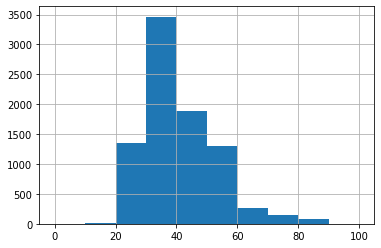

In [ ]:
data.age.hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
# here we see that the majority of the survey population is between 30 and 40 years old

In [ ]:
# We decided to bin together age in theese 4 groups as we deiced that it makes sense as to which stage of their life they are in, is considered similar. 
# By doing this we convert the age feature to an ordinal data type. 
def age(data):
    data.loc[data['age'] <= 30, 'age'] = 1
    data.loc[(data['age'] > 30) & (data['age'] <= 45), 'age'] = 2
    data.loc[(data['age'] > 45) & (data['age'] <= 65), 'age'] = 3
    data.loc[(data['age'] > 65) & (data['age'] <= 98), 'age'] = 4
           
    return data

age(data);

###### Converting binary and ordinal features into numeric values.

In [ ]:
#Converting binary variables in bank client data into numeric values using Labelencoder
#We do this due to the fact that SML is better at handeling numeric values rather than strings
labelencoder_X = LabelEncoder()   
data['housing']  = labelencoder_X.fit_transform(data['housing']) 
data['loan']     = labelencoder_X.fit_transform(data['loan']) 

Futhermore we do this for the categorial data with a natural order, like education, since having a university degree is considered of a higher value than having high school diploma

there are seven options and the order is obvious, except for the illiterate, who will be set as the least valueable education level, as it is defined as a handicap that might render an individual unable to join the workforce
the order will be: "illiterate" "basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"

Labelencoder sorts the values alphabetically, so we have to make sure that the illiterate value is beeing set to 0.

In [ ]:
# setting the name to a_illiterate to make sure Labelencoder sorts as to the above criteria
data['education'] = data['education'].replace({'illiterate':'a_illiterate'})

In [ ]:
# now we Labelencode the variable education
data['education'] = labelencoder_X.fit_transform(data['education']) 

## Related with the last contact of the current campaign & Other attributes
- variable number 8-15 as in the .txt file
- variables included in this section
###### 8. contact 9. month 10. dayofweek 11. duration 12. campaign 13. pdays 14. previous 15. poutcome

As according to the article the duration variable is first known after the call has ended. Therefore we drop it, because we can't use it in our model.

It is worth noting that the pdays feature is a numeric variable 

Definition as according to the .text file; 
  
  "number of days that passed by after the client was last contacted from a   previous campaign" (numeric; 999 means client was not previously contacted)

The 999 value of pdays, will give a scaling problem and we will deal with this in this subsection

In [ ]:
#Since duration first will be known after the call has been completed, we cant use this feature in our model
data.drop("duration",inplace=True,axis=1)

In [ ]:
#We are now looking at the featuregroups 'Related with the last contact of the current campaign' and 'Other attributes'
data.iloc[: , 6:13]

contact month day_of_week  campaign  pdays  previous     poutcome
9036   telephone   jun         thu        17    999         0  nonexistent
20673   cellular   aug         wed         1    999         0  nonexistent
12094  telephone   jun         fri         4    999         0  nonexistent
34537   cellular   may         thu         3    999         0  nonexistent
29132   cellular   apr         fri         1    999         0  nonexistent
...          ...   ...         ...       ...    ...       ...          ...
41174   cellular   nov         thu         1      1         6      success
41178   cellular   nov         thu         2      6         3      success
41181   cellular   nov         fri         1    999         0  nonexistent
41183   cellular   nov         fri         1    999         0  nonexistent
41186   cellular   nov         fri         1    999         0  nonexistent

[8516 rows x 7 columns]

In [ ]:
data.iloc[: , 6:13].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8516 entries, 9036 to 41186
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contact      8516 non-null   object
 1   month        8516 non-null   object
 2   day_of_week  8516 non-null   object
 3   campaign     8516 non-null   int64 
 4   pdays        8516 non-null   int64 
 5   previous     8516 non-null   int64 
 6   poutcome     8516 non-null   object
dtypes: int64(3), object(4)
memory usage: 532.2+ KB


In [ ]:
data.head()

age         job   marital  education  housing  loan    contact month  \
9036     2    services   married          3        0     0  telephone   jun   
20673    2      admin.   married          6        0     1   cellular   aug   
12094    2      admin.   married          4        1     1  telephone   jun   
34537    1  technician   married          4        1     0   cellular   may   
29132    2      admin.  divorced          6        1     0   cellular   apr   

      day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
9036          thu        17    999         0  nonexistent           1.4   
20673         wed         1    999         0  nonexistent           1.4   
12094         fri         4    999         0  nonexistent           1.4   
34537         thu         3    999         0  nonexistent          -1.8   
29132         fri         1    999         0  nonexistent          -1.8   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
9036           94.465          -41.8      4.866       5228.1  no  
20673          93.444          -36.1      4.965       5228.1  no  
12094          94.465          -41.8      4.947       5228.1  no  
34537          92.893          -46.2      1.266       5099.1  no  
29132          93.075          -47.1      1.405       5099.1  no

In [ ]:
# Printing the values of the categorial data to get a better overview
print('Unique values for contact:\n', data.contact.unique())
print('')
print('Unique values for month:\n', data.month.unique())
print('')
print('Unique values for day of week:\n', data.day_of_week.unique())
print('')
print('Unique values for day of poutcome:\n', data.poutcome.unique())
print('')

Unique values for contact:
 ['telephone' 'cellular']

Unique values for month:
 ['jun' 'aug' 'may' 'apr' 'nov' 'jul' 'sep' 'oct' 'mar' 'dec']

Unique values for day of week:
 ['thu' 'wed' 'fri' 'mon' 'tue']

Unique values for day of poutcome:
 ['nonexistent' 'failure' 'success']



In [ ]:
# Encoding binary decision variables into numeric values
# After inspecting the data there is only the feature "contact" that has a binary outcome
# further more theres is no ordinal data in this sub section
data['contact']      = labelencoder_X.fit_transform(data['contact']) 
#The values in the column contact: 0 = Celluar, 1 = Telephone 





In [ ]:
data.head()

age         job   marital  education  housing  loan  contact month  \
9036     2    services   married          3        0     0        1   jun   
20673    2      admin.   married          6        0     1        0   aug   
12094    2      admin.   married          4        1     1        1   jun   
34537    1  technician   married          4        1     0        0   may   
29132    2      admin.  divorced          6        1     0        0   apr   

      day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
9036          thu        17    999         0  nonexistent           1.4   
20673         wed         1    999         0  nonexistent           1.4   
12094         fri         4    999         0  nonexistent           1.4   
34537         thu         3    999         0  nonexistent          -1.8   
29132         fri         1    999         0  nonexistent          -1.8   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
9036           94.465          -41.8      4.866       5228.1  no  
20673          93.444          -36.1      4.965       5228.1  no  
12094          94.465          -41.8      4.947       5228.1  no  
34537          92.893          -46.2      1.266       5099.1  no  
29132          93.075          -47.1      1.405       5099.1  no

###### Onehot encoding our nominal data features

In [ ]:
#Defining our OneHotEncoder and assigning it ohe_X
ohe_X = OneHotEncoder(sparse=False)

In [ ]:
#OneHotEncoding our nominal categorical features
X_ohe = ohe_X.fit_transform(data.filter(items=['job','marital','month','day_of_week','poutcome']))

In [ ]:
# Converting the X_ohe from numpy array to dataframe and keeping the column names
X_ohe =pd.DataFrame(X_ohe, columns =list(itertools.chain(*ohe_X.categories_)))

In [ ]:
#We deal with the 999 numeric value in the feature pdays
def pdays(data):
    data.loc[data['pdays'] == 999, 'pdays'] = 0
    data.loc[data['pdays'] < 999, 'pdays'] = 1
           
    return data

pdays(data);

## Social and economic context attributes

- This group consist of only numeric values so all theese variables will be standardscaled
- This is variable 16-20 in the .txt file
- This group include: 16. emp.var.rate 17. cons.price.index 18. cons.conf.idx 19. euribor3m 20. nr.employed

In [ ]:
data.iloc[: , 13:18]

emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed
9036            1.4          94.465          -41.8      4.866       5228.1
20673           1.4          93.444          -36.1      4.965       5228.1
12094           1.4          94.465          -41.8      4.947       5228.1
34537          -1.8          92.893          -46.2      1.266       5099.1
29132          -1.8          93.075          -47.1      1.405       5099.1
...             ...             ...            ...        ...          ...
41174          -1.1          94.767          -50.8      1.031       4963.6
41178          -1.1          94.767          -50.8      1.031       4963.6
41181          -1.1          94.767          -50.8      1.028       4963.6
41183          -1.1          94.767          -50.8      1.028       4963.6
41186          -1.1          94.767          -50.8      1.028       4963.6

[8516 rows x 5 columns]

In [ ]:
data.iloc[:, 13:18].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8516 entries, 9036 to 41186
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   emp.var.rate    8516 non-null   float64
 1   cons.price.idx  8516 non-null   float64
 2   cons.conf.idx   8516 non-null   float64
 3   euribor3m       8516 non-null   float64
 4   nr.employed     8516 non-null   float64
dtypes: float64(5)
memory usage: 399.2 KB


In [ ]:
data.iloc[:, 13:18].describe()

emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed
count   8516.000000     8516.000000    8516.000000  8516.000000  8516.000000
mean      -0.494140       93.471038     -40.268154     2.967202  5136.163093
std        1.716197        0.629264       5.357423     1.884747    86.508188
min       -3.400000       92.201000     -50.800000     0.634000  4963.600000
25%       -1.800000       92.893000     -42.700000     1.250000  5076.200000
50%       -0.100000       93.444000     -41.800000     4.021000  5191.000000
75%        1.400000       93.994000     -36.400000     4.959000  5228.100000
max        1.400000       94.767000     -26.900000     5.045000  5228.100000

In [ ]:
#Using StandardScaler on ordinal features
scaler = StandardScaler()

In [ ]:
#Using StandardScaler on ordinal features
data_numeric = data.filter(items=['age','education','campaign','previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numeric)

In [ ]:
#Making our X_scaled to a Pandas Dataframe
X_scaled = pd.DataFrame(X_scaled, columns=['age','education','campaign','previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])

In [ ]:
#Labelencoding the out variable 
y = data.y
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

# Supervised Machine Learning
### we will be trying out 3 different models
- Logistic Regression
- XGboost
- RandomForest

In [ ]:
#Using the concatenate function to append our ordinal (StandardScaled) data with our nominal (OneHotEncoded)
X = pd.concat([X_ohe, X_scaled], axis=1)

### Logistic Regression

In [ ]:
#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
#Defining a LogisticRegressor
model_lr = LogisticRegression()

In [ ]:
# Fitting to train data
model_lr.fit(X_train, y_train)  # We note that this gives us a error

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [ ]:
#Printing the model score for our LogisicRegression to see how well our model performs
print('Model Logistic Regression train score:' + ' ' + str(model_lr.score(X_train, y_train)))
print('Model Logistic Regression test score :' + ' ' + str(model_lr.score(X_test, y_test))) 

Model Logistic Regression train score: 0.7392836171462126
Model Logistic Regression test score : 0.7235915492957746


Upon running this entire notebook 5 times, the model score of logistic regression deviates from 0,7417 to 0,7495

We therefore conclude than the random components in the model are acceptable since the deviation is less than 0,05

In [ ]:
#Using LabelEncoder's inverse transformation to get initial labels of the variables
true_yes_no = labelencoder_y.inverse_transform(y_train)

predicted_yes_no_lr = labelencoder_y.inverse_transform(model_lr.predict(X_train))


In [ ]:
# Confusion matrix on train data
c_matrix_lr = pd.DataFrame({'true_yes_no': true_yes_no, 'predicted_yes_no': predicted_yes_no_lr}) 

pd.crosstab(c_matrix_lr.true_yes_no, c_matrix_lr.predicted_yes_no)

predicted_yes_no    no   yes
true_yes_no                 
no                2924   486
yes               1290  2112

Above we see that our model is able to predict 2922 + 2109 true results. And further predicting 1306 + 475 false results

In [ ]:
# Classification report on train data.
print(classification_report(true_yes_no,predicted_yes_no_lr, labels=labelencoder_y.classes_)) 


              precision    recall  f1-score   support

          no       0.69      0.86      0.77      3410
         yes       0.81      0.62      0.70      3402

    accuracy                           0.74      6812
   macro avg       0.75      0.74      0.74      6812
weighted avg       0.75      0.74      0.74      6812



In [ ]:
#Using LabelEncoder's inverse transformation to get initial labels of the variables on test data
true_yes_no_test = labelencoder_y.inverse_transform(y_test)
predicted_yes_no_lr_test = labelencoder_y.inverse_transform(model_lr.predict(X_test))

In [ ]:
# Making a confusion matrix on test
c_matrix_lr_test = pd.DataFrame({'true_yes_no': true_yes_no_test, 'predicted_yes_no': predicted_yes_no_lr_test}) 

pd.crosstab(c_matrix_lr_test.true_yes_no, c_matrix_lr_test.predicted_yes_no)

predicted_yes_no   no  yes
true_yes_no               
no                711  137
yes               334  522

In [ ]:
# Classification report on test data
print(classification_report(true_yes_no_test,predicted_yes_no_lr_test, labels=labelencoder_y.classes_))

              precision    recall  f1-score   support

          no       0.68      0.84      0.75       848
         yes       0.79      0.61      0.69       856

    accuracy                           0.72      1704
   macro avg       0.74      0.72      0.72      1704
weighted avg       0.74      0.72      0.72      1704



X does not have valid feature names, but LogisticRegression was fitted with feature names
detected multi-dimensional feature importances but stack=False, using mean to aggregate them.


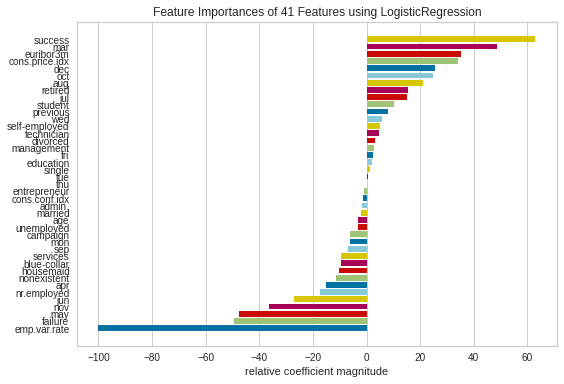

In [ ]:
# Feature importance
from yellowbrick.features import FeatureImportances

viz = FeatureImportances(model_lr)
viz.fit(X, y)
viz.show()

We note that the feature "mar" has a high importance. This can be explained because a highy share of calls was performed in this month.

Further social and eciomic context attributes has a high importance, which was expected from the start

## XGBClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Instanciating XGBClassifier
model_xgb = XGBClassifier()

In [ ]:
# Fitting to train data
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
print('Model XGB train score:' + ' ' + str(model_xgb.score(X_train, y_train)))
print('Model XGB test score :' + ' ' + str(model_xgb.score(X_test, y_test)))

Model XGB train score: 0.8374926600117439
Model XGB test score : 0.732981220657277


In [ ]:
# Reversing labels
predicted_yes_no_xgb = labelencoder_y.inverse_transform(model_xgb.predict(X_train))

In [ ]:
# Constructing confusion matrix for XGB model on train data
c_matrix_xgb = pd.DataFrame({'true_yes_no': true_yes_no, 'predicted_yes_no': predicted_yes_no_xgb}) 

pd.crosstab(c_matrix_xgb.true_yes_no, c_matrix_xgb.predicted_yes_no)

predicted_yes_no    no   yes
true_yes_no                 
no                3121   289
yes                818  2584

In [ ]:
# Classification report to get an overview of performance (train data)
print(classification_report(true_yes_no,predicted_yes_no_xgb, labels=labelencoder_y.classes_))

              precision    recall  f1-score   support

          no       0.79      0.92      0.85      3410
         yes       0.90      0.76      0.82      3402

    accuracy                           0.84      6812
   macro avg       0.85      0.84      0.84      6812
weighted avg       0.85      0.84      0.84      6812



In [ ]:
# Reversing labels
predicted_yes_no_xgb_test = labelencoder_y.inverse_transform(model_xgb.predict(X_test))

In [ ]:
# Constructing confusion matrix for XGB model on test data
c_matrix_xgb_test = pd.DataFrame({'true_yes_no': true_yes_no_test, 'predicted_yes_no': predicted_yes_no_xgb_test}) 

pd.crosstab(c_matrix_xgb_test.true_yes_no, c_matrix_xgb_test.predicted_yes_no)

predicted_yes_no   no  yes
true_yes_no               
no                679  169
yes               286  570

In [ ]:
# Classification report to get an overview of performance (test data)
print(classification_report(true_yes_no_test,predicted_yes_no_xgb_test, labels=labelencoder_y.classes_))

              precision    recall  f1-score   support

          no       0.70      0.80      0.75       848
         yes       0.77      0.67      0.71       856

    accuracy                           0.73      1704
   macro avg       0.74      0.73      0.73      1704
weighted avg       0.74      0.73      0.73      1704



## RandomForest

In [ ]:
model_rf = RandomForestClassifier()

In [ ]:
# Fitting model
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Checking score
print('Model Random Forest train score:' + ' ' + str(model_rf.score(X_train, y_train)))
print('Model Random Forest test score :' + ' ' + str(model_rf.score(X_test, y_test)))

Model Random Forest train score: 0.9725484439224897
Model Random Forest test score : 0.7059859154929577


In [ ]:
# Recalling original labels
predicted_yes_no_rf = labelencoder_y.inverse_transform(model_rf.predict(X_train))

In [ ]:
#Constructing a confussion matrix on training data
c_matrix_rf = pd.DataFrame({'true_yes_no': true_yes_no, 'predicted_yes_no': predicted_yes_no_rf}) 

pd.crosstab(c_matrix_rf.true_yes_no, c_matrix_rf.predicted_yes_no)

predicted_yes_no    no   yes
true_yes_no                 
no                3329    81
yes                106  3296

In [ ]:
# Classification report
print(classification_report(true_yes_no,predicted_yes_no_rf, labels=labelencoder_y.classes_))

              precision    recall  f1-score   support

          no       0.97      0.98      0.97      3410
         yes       0.98      0.97      0.97      3402

    accuracy                           0.97      6812
   macro avg       0.97      0.97      0.97      6812
weighted avg       0.97      0.97      0.97      6812



In [ ]:
# Calling the original labels
predicted_yes_no_rf_test = labelencoder_y.inverse_transform(model_rf.predict(X_test))

In [ ]:
# Confusion matrix on test values for model RF
c_matrix_rf_test = pd.DataFrame({'true_yes_no': true_yes_no_test, 'predicted_yes_no': predicted_yes_no_rf_test}) 

pd.crosstab(c_matrix_rf_test.true_yes_no, c_matrix_rf_test.predicted_yes_no)

predicted_yes_no   no  yes
true_yes_no               
no                633  215
yes               286  570

In [ ]:
# Classification report for RF on test data
print(classification_report(true_yes_no_test,predicted_yes_no_rf_test, labels=labelencoder_y.classes_))

              precision    recall  f1-score   support

          no       0.69      0.75      0.72       848
         yes       0.73      0.67      0.69       856

    accuracy                           0.71      1704
   macro avg       0.71      0.71      0.71      1704
weighted avg       0.71      0.71      0.71      1704



Shap for our XGB model 
- since its the one we choose for the predicting whether a customer are going to say yes or no to the banks offer. We did choose this model due to the accuracy, and the fact that LR keeps giving us a limit error.

In [ ]:
explainer = shap.TreeExplainer(model_xgb)

In [ ]:
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


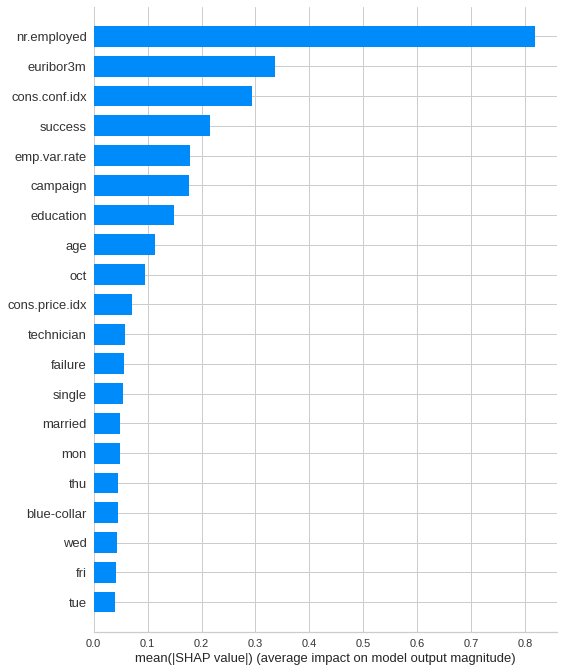

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

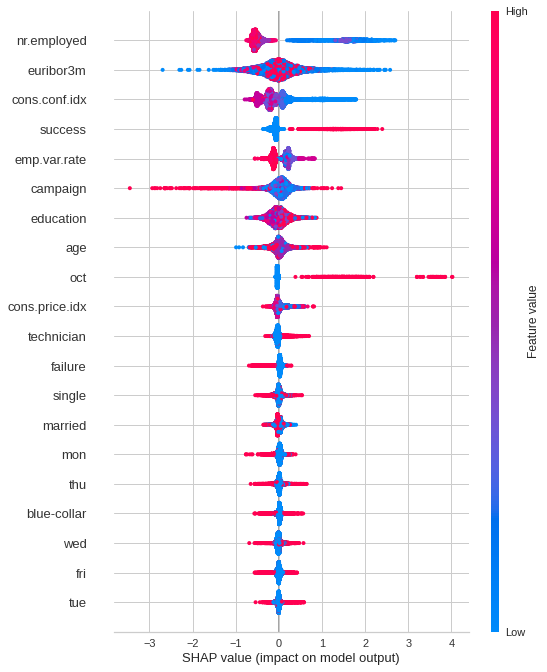

In [ ]:
#Seeing SHAP values for all features
shap.summary_plot(shap_values, X)

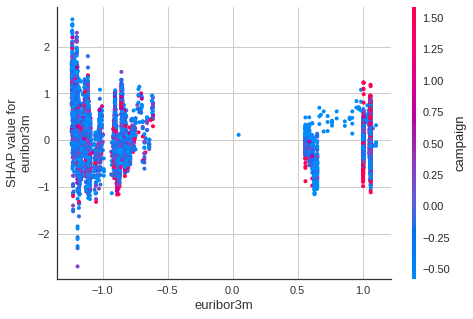

In [ ]:
#Seeing SHAP value for a specific feature
shap.dependence_plot("euribor3m", shap_values, X)

## Exporting our SML model

In [ ]:
import pickle

In [ ]:
model_xgb.save_model('model_xgb.json')

In [ ]:
pickle.dump(scaler, open('scaler.pkl','wb'))

In [ ]:
pickle.dump(ohe_X, open('ohe.pkl','wb'))

In [ ]:
X.to_json('X.json')
data.to_json('data.json')

In [ ]:
pickle.dump(model_xgb, open('model_xgb.pkl','wb'))

In [ ]:
pickle.dump(shap_values, open('shap_values.pkl','wb'))

# Unsupervised Machine Learning

In [ ]:
#Making our umap scaler
umap_scaler = umap.UMAP()

In [ ]:
#getting the relevant columns for our clustering (bank client informations)
X2 = data_raw.iloc[:, 0:6]

In [ ]:
#Dividing age into categories
def age(X2):
    X2.loc[X2['age'] <= 30, 'age'] = 1
    X2.loc[(X2['age'] > 30) & (X2['age'] <= 45), 'age'] = 2
    X2.loc[(X2['age'] > 45) & (X2['age'] <= 65), 'age'] = 3
    X2.loc[(X2['age'] > 65) & (X2['age'] <= 98), 'age'] = 4
           
    return X2

age(X2);

In [ ]:
#the yes/no of housing/loan is made into 1/0
#the different jobs are made into a subjective list based on income
X2 = X2.replace(to_replace=['yes', 'no'], value=[1, 0])
X2 = X2.replace(to_replace=['unemployed', 'student', 'housemaid', 'blue-collar', 'services', 'retired', 'technician', 'admin.', 'self-employed', 'entrepreneur', 'management'], value=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [ ]:
#labelencoding education as it is ordinal data.
#label encoder defaults to alphabetical and with this change it fits.
labelencoder_X = LabelEncoder()  
X2['education'] = X2['education'].replace({'illiterate':'a_illiterate'})
X2['education'] = labelencoder_X.fit_transform(X2['education'])

In [ ]:
#seeing if our changes work
X2.head()

age  job  marital  education  housing  loan
0    3    2  married          1        0     0
1    3    4  married          4        0     0
2    2    4  married          4        1     0
3    2    7  married          2        0     0
4    3    4  married          4        0     1

below here is a set of commented commands.
these are the leftovers of trying to OneHotEncode job and marital. For reasons unknown the concat resulted in dropping ~2600 rows and therefore couldn't be used.
Instead a somewhat subjective list was made for job and marital dropped so as to avoid too many poorly treated variables.

In [ ]:
#X2_ohe = ohe_X.fit_transform(X2.filter(items=['job', marital']))

In [ ]:
#X2_ohe = pd.DataFrame(X2_ohe, columns =list(itertools.chain(*ohe_X.categories_)))

In [ ]:
X2 = X2.drop(columns = 'marital')
#X2 = X2.drop(columns = 'job')

In [ ]:
#X2 = pd.concat([X2, X2_ohe], axis = 1, join='inner')

In [ ]:
#scaling our new dataset
X2_scaled = scaler.fit_transform(X2)

In [ ]:
#umap accepts standard-scaled data
embeddings = umap_scaler.fit_transform(X2_scaled)

In [ ]:
#we choose 6 clusters
clusterer = KMeans(n_clusters=6)

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X2_scaled)
    Sum_of_squared_distances.append(km.inertia_)

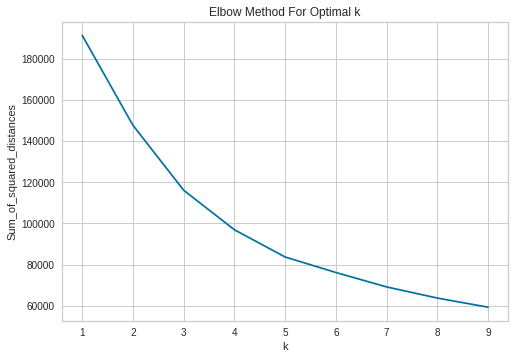

In [ ]:
#no clear elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

clustering can and sometimes is used together with dimensionality reduction.
In the end, it's about how much the used combination of approaches create representations of the data that are useful for the analysis.

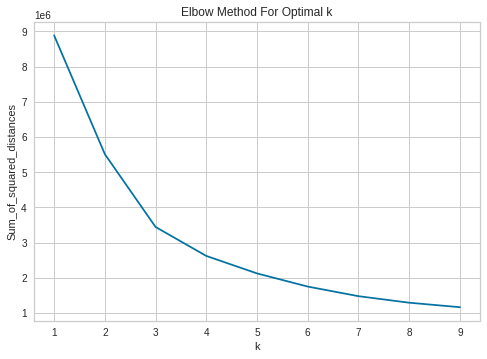

In [ ]:
#still no clear elbow
#only 5 components after dropping marital
umap_scaler_km = umap.UMAP(n_components=5)
embeddings_km = umap_scaler.fit_transform(X2_scaled)


Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(embeddings_km)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
#we fit clusters on our scaled data
clusterer.fit(X2_scaled)

KMeans(n_clusters=6)

In [ ]:
#we then copy the clusters into the original file
data_raw['cluster'] = clusterer.labels_

In [ ]:
#can use the clusters to fx. see the mean of age in our clusters.
#note that age does not seem a big factor in clustering as the mean is mostly the same.
data_raw.groupby('cluster').age.mean()

cluster
0    34.563178
1    39.215398
2    54.585952
3    34.307514
4    39.448959
5    39.061834
Name: age, dtype: float64

In [ ]:
#prepping our vis_data
vis_data = pd.DataFrame(embeddings)
vis_data['cluster'] = data_raw['cluster']
vis_data['education'] = data_raw['education']
vis_data['age'] = data_raw['age']
vis_data['job'] = data_raw['job']
vis_data['marital'] = data_raw['marital']
vis_data['housing'] = data_raw['housing']
vis_data['loan'] = data_raw['loan']

vis_data.columns = ['x', 'y', 'cluster','education', 'age', 'job', 'marital', 'housing', 'loan']

In [ ]:
#finally plotting the data with relevant tooltips
#for unknown reasons a null cluster is made alongside our other clusters
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(vis_data).mark_circle(size=60).encode(
    x='x',
    y='y',
    tooltip=['education', 'age', 'job', 'marital', 'housing', 'loan'],
    color=alt.Color('cluster:N', scale=alt.Scale(scheme='dark2')) #use N after the var to tell altair that it's categorical
).interactive()

alt.Chart(...)

In [ ]:
#There is no null value in X2
X2.isnull().values.any()

False

In [ ]:
#returning our scaled values to a pandas dataframe to check
X2_scaled_pd = pd.DataFrame(X2_scaled)

In [ ]:
#still no null values.
X2_scaled_pd.isnull().values.any()

False